# **4.6 랜덤 포레스트의 특성 중요도 사용**

**유용한 특성을 선택하는 또 다른 방법**은 앙상블 기법인 **랜덤 포레스트**를 사용하는 것이다.<br>
*랜덤 포레스트(random forest): 여러 개의 결정 트리를 평균 내는 것*

<br>

랜덤 포레스트를 사용하면 앙상블에 참여한 모든 결정 트리에서 계산한 '평균적인 불순도 감소'로 **특성 중요도를 측정**할 수 있다.<br>
따라서 데이터셋이 **선형적으로 구분 가능한지** 여부를 **가정할 필요가 없다**.

<br>

---

<br>

다음 코드에서는 Wine 데이터셋에서 500개의 트리를 가진 랜덤 포레스트를 훈련하고 각각의 **중요도에 따라** 13개의 **특성에 순위**를 매긴다.<br>

*참고로 트리 기반 모델은 표준화나 정규화가 필요 없다.*

 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529
 6) Hue                            0.058739
 7) Total phenols                  0.050872
 8) Magnesium                      0.031357
 9) Malic acid                     0.025648
10) Proanthocyanins                0.025570
11) Alcalinity of ash              0.022366
12) Nonflavanoid phenols           0.013354
13) Ash                            0.013279


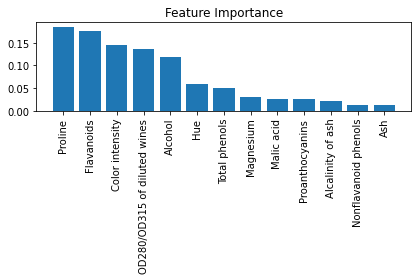

In [32]:
from sklearn.ensemble import RandomForestClassifier

feat_labels = df_wine.columns[1:]

forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,
                          feat_labels[indices[f]],
                          importances[indices[f]]))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

**특성 중요도(Feature Importance)**는 합이 1이 되도록 정규화된 값이다.<br><br>


500개의 결정 트리에서 '평균적인 불순도 감소'를 기반으로 이 데이터셋에서 **가장 판별력이 좋은 특성** 5가지<br>

    Proline, Flavanoids, Color intensity, OD280/OD315 of diluted wines, Alcohol
*재미있는 사실은 높은 순위의 특성 **5개 중 2개**는 SBS 알고리즘으로 선택한 3개에 포함되어 있다. (```Alcohol, OD280/OD315 of diluted wines```)*<br><br>


*※ 모델 해석을 중요하게 고려한다면 중요한 참고사항*<br>
*랜덤 포레스트에서 **두 개 이상**의 특성이 매우 **상관관계가 높다면** 하나의 특성은 매우 높은 순위를 갖지만, **다른 특성 정보는 완전히 잡아내지 못할 수 있다**.<br>
특성 중요도 값을 해석하는 것보다 모델의 예측 성능에만 관심이 있다면 신경쓸 필요 없다.*

<br>



In [33]:
from sklearn.feature_selection import SelectFromModel

sfm = SelectFromModel(forest, threshold=0.1, prefit=True)
X_selected = sfm.transform(X_train)
print('이 임계 조건을 만족하는 샘플의 수: ', X_selected.shape[1])

for f in range(X_selected.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30,
                          feat_labels[indices[f]],
                          importances[indices[f]]))

이 임계 조건을 만족하는 샘플의 수:  5
 1) Proline                        0.185453
 2) Flavanoids                     0.174751
 3) Color intensity                0.143920
 4) OD280/OD315 of diluted wines   0.136162
 5) Alcohol                        0.118529


**```SelectFromModel``` 클래스**
- 모델 훈련이 끝난 뒤 **사용자가 지정한 임계 값**(```threshold```)을 기반으로 **특성을 선택**한다.<br>
- **```RandomForestClassifier```**를 특성 선택기로 사용할 때 유용하다.<br>

<br>

---

<br>



**RFE(Recursive Feature Elimination): 재귀적 특성 제거 방법**<br>
1. 모든 특성을 사용하여 모델을 만들고 특성 중요도가 가장 낮은 특성을 제거한다.
2. 제외된 특성을 빼고 나머지 특성으로 새로운 모델을 만든다.
3. 미리 정의한 특성 개수가 남을 때까지 반복한다.

<br>

RFE 클래스:

        def __init__(estimator, n_features_to_select=None, step=1, verbose=0)

<br>

매개변수:

**```n_features_to_select```**<br>
- **선택할 특성의 개수**를 지정한다. 
- 기본값은 입력 특성 개수의 절반이다.


**```step```**<br>
- 각 반복에서 **제거할 특성의 개수**를 지정한다.
- (0, 1) 사이의 값을 지정하면 삭제할 특성의 비율이 된다.
- 기본값은 1이다.

<br>


기본적으로 **```coef_```**나 **```feature_importances_``` 속성을 기준**으로 **특성을 제거**한다.

<br>



In [34]:
from sklearn.feature_selection import RFE
rfe = RFE(forest, n_features_to_select=5)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                     class_weight=None, criterion='gini',
                                     max_depth=None, max_features='auto',
                                     max_leaf_nodes=None, max_samples=None,
                                     min_impurity_decrease=0.0,
                                     min_impurity_split=None,
                                     min_samples_leaf=1, min_samples_split=2,
                                     min_weight_fraction_leaf=0.0,
                                     n_estimators=500, n_jobs=None,
                                     oob_score=False, random_state=1, verbose=0,
                                     warm_start=False),
    n_features_to_select=5, step=1, verbose=0)

In [35]:
rfe.ranking_

array([1, 5, 9, 6, 4, 3, 1, 8, 7, 1, 2, 1, 1])

**```ranking_``` 속성**에는 **선택한 특성의 우선순위**가 들어 있다.<br>
- 1은 모델이 선택한 다섯 개의 특성이다.

<br>


In [36]:
f_mask = rfe.support_

선택된 특성은 **```support_``` 속성에 ```True```로 표시**된다.<br>

이 값을 ```f_mask```로 저장하면 특성의 이름을 표시하는 데 사용할 수 있다.

<br>

In [38]:
importances = rfe.estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
for i in indices:
  print("%2d) %-*s %f" % (f + 1, 30,
                          feat_labels[f_mask][i],
                          importances[i]))

 5) Proline                        0.261512
 5) Color intensity                0.216477
 5) Flavanoids                     0.212259
 5) OD280/OD315 of diluted wines   0.188924
 5) Alcohol                        0.120828


**훈련된 기반 모델**(랜덤 포레스트)은 **```estimator_``` 속성에 저장**되어 있다.<br>

이 모델은 **```n_features_to_select```개의 특성을 사용**하여 **훈련된 모델**이다.<br><br>

이 모델의 특성 중요도를 저장하여 앞에서와 같이 **중요도 순서대로 출력**했다.<br>
기반 모델을 같은 **랜덤 포레스트**로 사용해서, **```SelectFromModel``` 클래스로 선택한 특성**과 순서를 빼고 나머진 **같다**.

<br>

---
